# XGBoost MODEL BUILD

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

## Load Train and Test Datasets

In [2]:
df_train = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/train.csv')
df_test = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/test.csv')

In [3]:
X_train = df_train.drop(['label'], axis=1)  # Features
y_train = df_train['label']  # Target variable

In [4]:
X_test = df_test.drop(['label'], axis=1)  # Features
y_test = df_test['label']  # Target variable

In [5]:
X_train, X_train_test, y_train, y_train_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Model Creation and Training

In [6]:
X_train.shape,y_train.shape

((205989, 7), (205989,))

In [7]:
X_train_test.shape, y_train_test.shape

((51498, 7), (51498,))

In [8]:
X_test.shape,y_test.shape

((28609, 7), (28609,))

In [9]:
model = XGBClassifier(
    n_estimators=1500,  
    max_depth=5,        
    learning_rate=0.05,  
    objective='binary:logistic'
)

In [10]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
# Save the trained model to a specific folder
model_folder = "../../3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_XGBoost.joblib"
model_path = model_folder + model_filename

joblib.dump(model, model_path)
print(f"XGBoost model saved to: {model_path}")

XGBoost model saved to: ../../3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_XGBoost.joblib


In [12]:
# Load the saved model
model = joblib.load(model_path)

In [13]:
# Validation
pred = model.predict(X_train_test)

# Results

## With Training

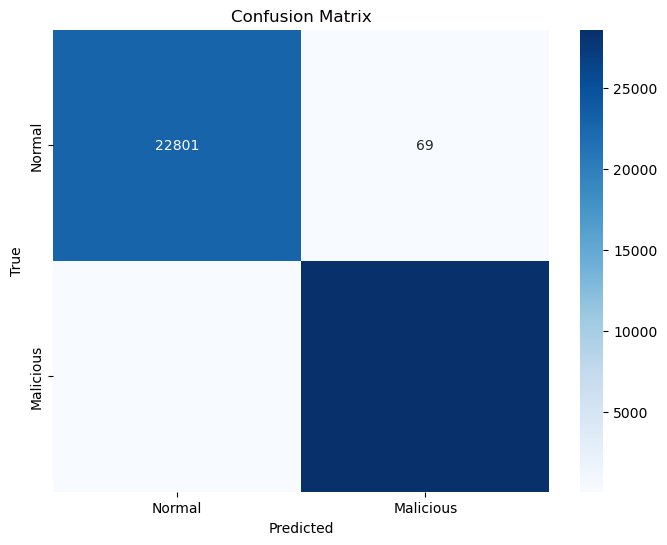

In [14]:
cm = confusion_matrix(y_train_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Malicious'], 
            yticklabels=['Normal', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
accuracy = accuracy_score(y_train_test, pred)
precision = precision_score(y_train_test, pred)
recall = recall_score(y_train_test, pred)
f1 = f1_score(y_train_test, pred)

print("Accuracy:   {:.2%}".format(accuracy))
print("Precision:  {:.2%}".format(precision))
print("Recall:     {:.2%}".format(recall))
print("F1-score:   {:.2%}".format(f1))

Accuracy:   99.78%
Precision:  99.76%
Recall:     99.84%
F1-score:   99.80%


# with Test Dataset

In [16]:
pred_test = model.predict(X_test)

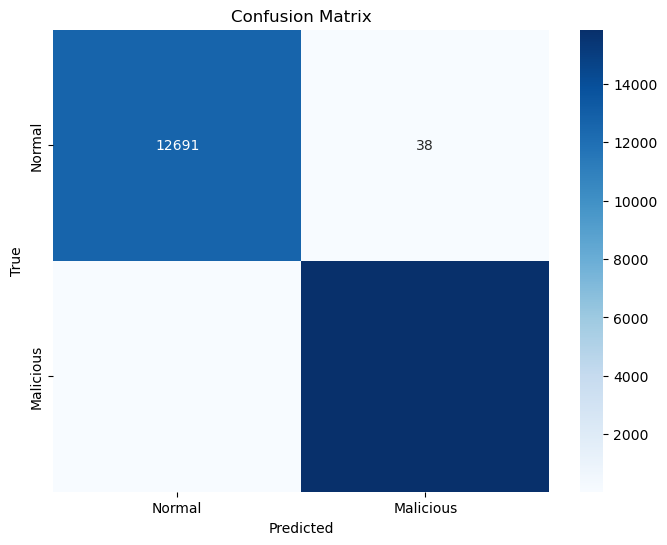

In [17]:
cm = confusion_matrix(y_test, pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Malicious'], 
            yticklabels=['Normal', 'Malicious'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Compute accuracy
accuracy = accuracy_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
recall = recall_score(y_test, pred_test)
f1 = f1_score(y_test, pred_test)

print("Accuracy:   {:.2%}".format(accuracy))
print("Precision:  {:.2%}".format(precision))
print("Recall:     {:.2%}".format(recall))
print("F1-score:   {:.2%}".format(f1))

Accuracy:   99.75%
Precision:  99.76%
Recall:     99.79%
F1-score:   99.77%
